### Importing required Libraries

In [6]:
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image
from keras.preprocessing import image


import cv2 as cv
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [7]:
train_dir = r"C:\Users\jayme\OneDrive\Desktop\ML Youtube\5. Computer Vision\Projects\Emotion Detection\content\train"

In [8]:
test_dir = r"C:\Users\jayme\OneDrive\Desktop\ML Youtube\5. Computer Vision\Projects\Emotion Detection\content\test"

### Image Data Generator

In [9]:
train_datagen = ImageDataGenerator(
    width_shift_range = 0.1,        # Randomly shift the width of images by up to 10%
    height_shift_range = 0.1,       
    horizontal_flip = True,         # Flip images horizontally at random
    rescale = 1./255,               # Rescale pixel values to be between 0 and 1
    validation_split = 0.2          # Set aside 20% of the data for validation
)

validation_datagen = ImageDataGenerator(
    rescale = 1./255,               # Rescale pixel values to be between 0 and 1
    validation_split = 0.2          # Set aside 20% of the data for validation
)

In [10]:
train_generator = train_datagen.flow_from_directory(
    directory = train_dir,           # Directory containing the training data
    target_size = (48, 48),          # Resizes all images to 48x48 pixels
    batch_size = 64,                 
    color_mode = "grayscale",        
    class_mode = "categorical",      # Classifies the images into 7 categories
    subset = "training"              # Uses the training subset of the data
)

validation_generator = validation_datagen.flow_from_directory(
    directory = test_dir,            # Directory containing the validation data
    target_size = (48, 48),          # Resizes all images to 48x48 pixels
    batch_size = 64,                 # Number of images per batch
    color_mode = "grayscale",        # Converts the images to grayscale
    class_mode = "categorical",      # Classifies the images into 7 categories
    subset = "validation"            # Uses the validation subset of the data
)

Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


In [11]:
len(train_generator)

359

### Displaying sample images

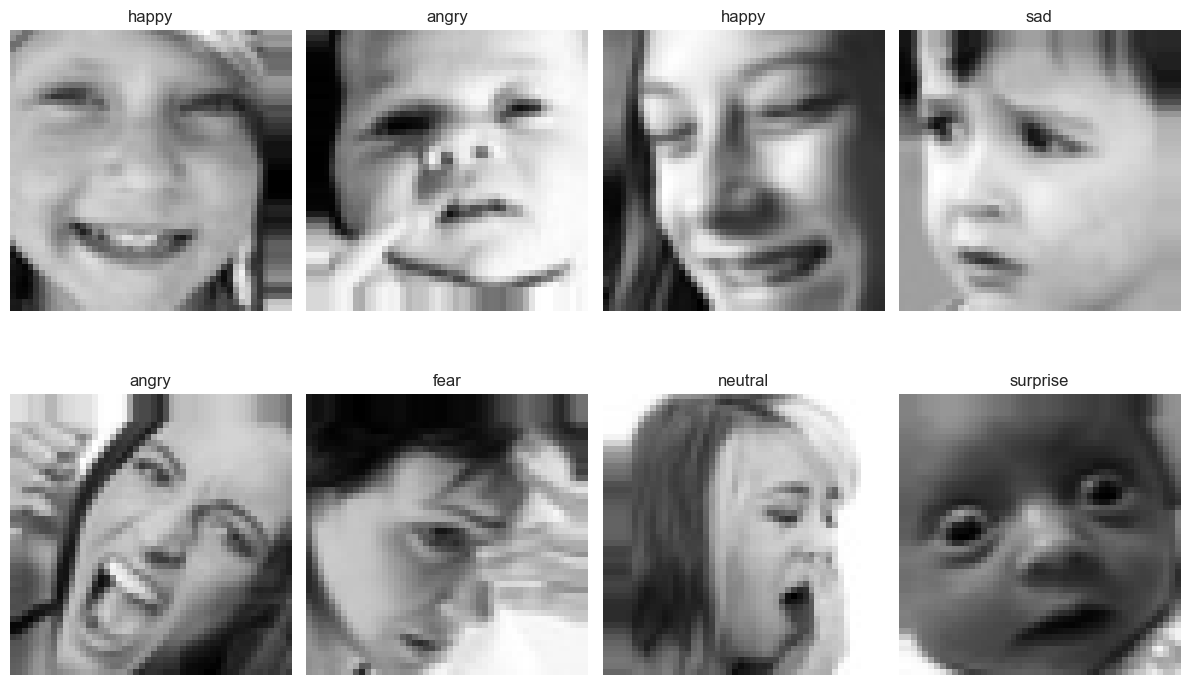

In [12]:
sample_images, sample_labels = next(train_generator)

# Map numerical labels to class names
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())

# Display 8 sample images with labels
plt.figure(figsize=(12, 8))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(sample_images[i].reshape(48, 48), cmap='gray')  
    label_index = sample_labels[i].argmax()  # Gets the label with the max value
    label_name = class_names[label_index]  # Map numerical label to class name
    plt.title(f'{label_name}') 
    plt.axis('off')  
plt.tight_layout()
plt.show()

### Model

In [13]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())

model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 44, 44, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 44, 44, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 20, 20, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,441,415 (5.50 MB)

 Trainable params: 1,439,943 (5.49 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define file path for model checkpoint
checkpoint_path = "model_checkpoint.keras"

# Define ModelCheckpoint callback to save the best model during training
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',  # monitor validation loss
    mode='min',          # minimize validation loss
    save_best_only=True, # save only the best model
    verbose=1            # show the progress
)

# Define EarlyStopping callback to stop training if validation loss stops improving
early_stopping_callback = EarlyStopping(
    monitor='val_loss',  
    mode='min',          
    patience=3,          # Number of epochs with no improvement before stopping
    verbose=1            
)

**Fitting the model.**

In [16]:
history = model.fit(
    train_generator,
    #steps_per_epoch = len(train_generator),
    epochs = 10,
    validation_data = validation_generator,
    #validation_steps = len(validation_generator),
    callbacks = [checkpoint_callback, early_stopping_callback]  # pass both callbacks
)

Epoch 1/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.3484 - loss: 1.7236 - precision: 0.5115 - recall: 0.1552
Epoch 1: val_loss improved from inf to 1.53924, saving model to model_checkpoint.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 152s 419ms/step - accuracy: 0.3485 - loss: 1.7234 - precision: 0.5117 - recall: 0.1553 - val_accuracy: 0.4064 - val_loss: 1.5392 - val_precision: 0.6047 - val_recall: 0.2318
Epoch 2/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.4438 - loss: 1.4597 - precision: 0.6538 - recall: 0.2498
Epoch 2: val_loss improved from 1.53924 to 1.30343, saving model to model_checkpoint.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 55s 153ms/step - accuracy: 0.4438 - loss: 1.4596 - precision: 0.6539 - recall: 0.2499 - val_accuracy: 0.5063 - val_loss: 1.3034 - val_precision: 0.7427 - val_recall: 0.2842
Epoch 3/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.4970 - loss: 1.3349 - precision: 0.7097 - recall: 0.2875
Epoch 3: val_loss improved from 1.30343 to

### Model Report

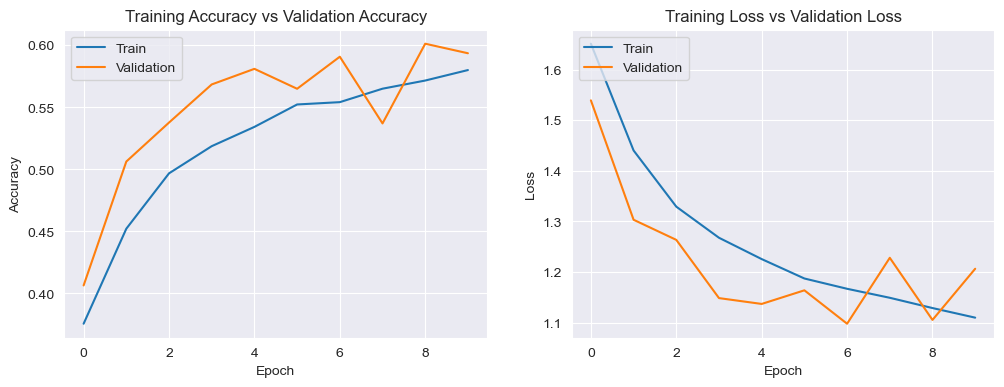

In [17]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [18]:
preds = model.predict(validation_generator)
y_pred = np.argmax(preds, axis=1)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


In [19]:
y_pred

array([6, 4, 4, ..., 3, 4, 4], dtype=int64)

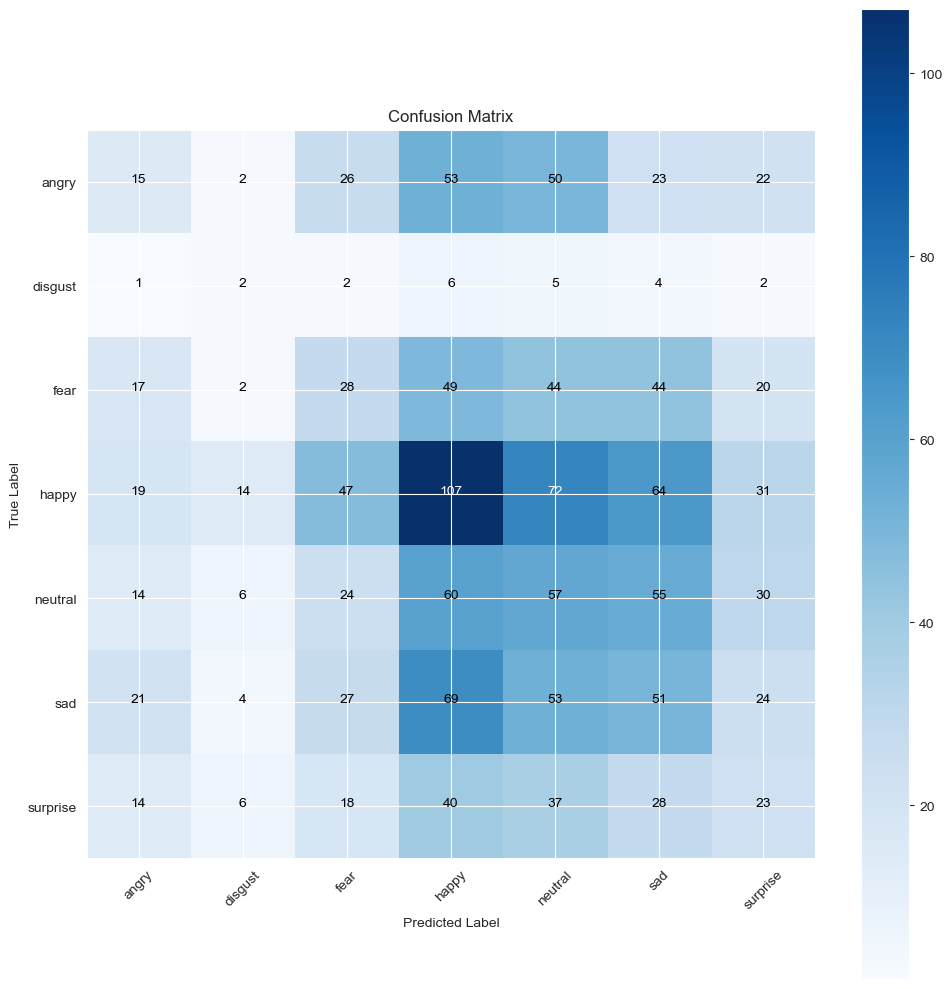

In [20]:
g_dict = validation_generator.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(validation_generator.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 1.5
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

### Classification Report

In [21]:
print(classification_report(validation_generator.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

       angry       0.15      0.08      0.10       191
     disgust       0.06      0.09      0.07        22
        fear       0.16      0.14      0.15       204
       happy       0.28      0.30      0.29       354
     neutral       0.18      0.23      0.20       246
         sad       0.19      0.20      0.20       249
    surprise       0.15      0.14      0.14       166

    accuracy                           0.20      1432
   macro avg       0.17      0.17      0.16      1432
weighted avg       0.19      0.20      0.19      1432



### Predicting using Saved Model

In [22]:
loaded_model = tf.keras.models.load_model(r"C:\Users\jayme\OneDrive\Desktop\ML Youtube\5. Computer Vision\Projects\Emotion Detection\model_checkpoint.keras", compile=False)
loaded_model.compile(
    Adamax(learning_rate= 0.001), 
    loss= 'categorical_crossentropy', 
    metrics= ['accuracy']
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
fear
(48, 48)


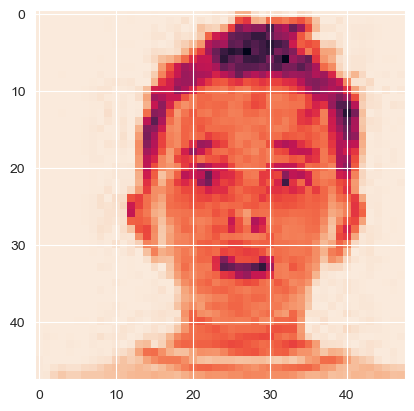

In [30]:
image_path = r"C:\Users\jayme\OneDrive\Desktop\ML Youtube\5. Computer Vision\Projects\Emotion Detection\content\test\fear\PrivateTest_5429150.jpg"
image = Image.open(image_path)

# Preprocess the image
img = image.resize((48, 48))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)


# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

img = np.array(img)
plt.imshow(img)
print(img.shape)

**As we can see above, our picture was taken from the 'fear' folder from the test directory and it was correctly predicted**